In [6]:
include("src/polyatree.jl")
include("src/partitions.jl")

using Distributions
using Plots
using Serialization
using DataFrames
using LaTeXStrings
using Plots.PlotMeasures


# Example 1) Finite vs infinite Polya Tree

In [118]:
data1 = rand(Uniform(0, 0.5), 1000)
data2 = [rand(Uniform(0, 0.25), 1000); rand(Uniform(0.125, 0.25), 3000); rand(Uniform(0.5, 1.0), 2000)];
data3 = rand(truncated(Normal(0.5, 0.1), 0.0, 1.0), 1000);

datasets = [data1, data2, data3];

In [186]:
data = rand(Uniform(0, 0.5), 500000)
gfpt2 = GFPT1(Poisson(5.0), 10, 0.05, 0.05)
gfpt2 = update(data, gfpt2)

sum(collect(1:length(gfpt2.prob_n)) .* gfpt2.prob_n)

gfpt2.prob_n

1.1147763801490618

In [188]:
function l1_dist(p_dens, q_dens, xgrid)
    return 0.5 * sum(abs.(p_dens .- q_dens)) * (xgrid[2] - xgrid[1])
end


function arclength(curve, xgrid, normalize=true)
    diffs = curve[2:end] .- curve[1:end-1]
    deltas = xgrid[2:end] .- xgrid[1:end-1]
    out = sum(
        (diffs.^2 .+ deltas.^2).^(1/2)
    )
    if normalize
        out -= sum(deltas)
    end
    return out
end

1

0.6749768077866957  0.6544622592645446
0.8427839256578469  0.8431627223953092
0.13564771703417083  0.06842851985708827


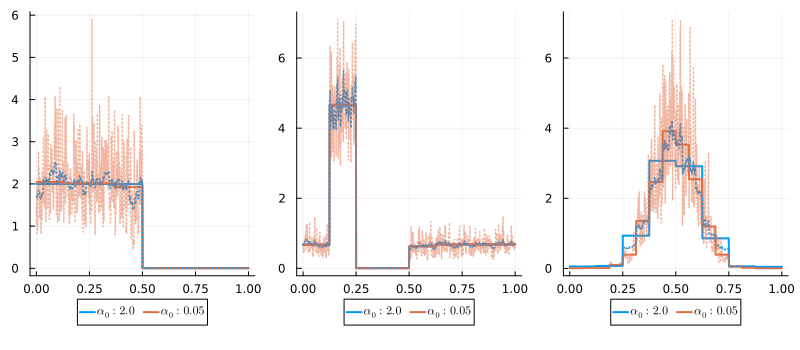

In [197]:
xgrid = collect(LinRange(1e-7, 1.0 - 1e-7, 1000))
plots = []

for data in datasets
    gfpt1 = GFPT1(Poisson(5.0), 10, 2.0, 2.0)
    simple_pt1 = deepcopy(gfpt1.pt)

    gfpt2 = GFPT1(Poisson(5.0), 10, 0.05, 0.05)
    simple_pt2 = deepcopy(gfpt2.pt)

    simple_pt3 = PolyaTree(10, 10.0, 10.0)

    gfpt1 = update(data, gfpt1)
    simple_pt1 = update(data, simple_pt1)
    gfpt2 = update(data, gfpt2)
    simple_pt2 = update(data, simple_pt2)
    simple_pt3 = update(data, simple_pt3)

    ref_dens = pdf.(truncated(Normal(0.5, 0.1), 0.0, 1.0), xgrid)
    pred1 = predictive_density(xgrid, simple_pt2)
    pred2 = predictive_density(xgrid, gfpt2)
    p = plot()

    plot!(xgrid, predictive_density(xgrid, gfpt1), color=1, label=L"\alpha_0: 2.0", linewidth=2.0)
    plot!(xgrid, pred2, color=2,linewidth=2.0, label=L"\alpha_0: 0.05")

    plot!(xgrid, predictive_density(xgrid, simple_pt1), color=1, linestyle=:dot, label="", linewidth=1.5)
    plot!(xgrid, pred1, color=2,linewidth=1.5, alpha=0.5, linestyle=:dot, label="")

    

    tv1 = (0.5 * sum(abs.(pred1 .- ref_dens)) * (xgrid[2] - xgrid[1]))
    tv2 = (0.5 * sum(abs.(pred2 .- ref_dens)) * (xgrid[2] - xgrid[1]))
    println(tv1, "  ", tv2)
    plots = push!(plots, p)
end


plot((p for p in plots)..., layout=(1, 3), size=(800, 350))
plot!(legend=:outerbottom, legendcolumns=2)

#savefig("plots/example1.pdf")

In [7]:
df = Serialization.deserialize("simulation1_results.dta");

In [8]:
PRIORS = [
    ("PT", 0.05),
    ("PT", 2.0),
    ("PT", 10.0),
    ("GFPT1", 0.05),
    ("GFPT1", 2.0),
    ("GFPT1", 10.0),
]

NDATAS = [50, 100, 1000, 5000, 10000];

In [9]:
mean_df = combine(groupby(df, [:Model, :alpha0, :DataGen, :Ndata]), 
                  :L1 => mean => :L1, :LENGTH => mean => :LENGTH,
                :POST_N => mean => :POST_N, :MODE_N => mean => :MODE_N);

median_df = combine(groupby(df, [:Model, :alpha0, :DataGen, :Ndata]), 
                :L1 => median => :L1, :LENGTH => median => :LENGTH,
                :POST_N => median => :POST_N, :MODE_N => median => :MODE_N);

In [12]:
TO_PLOT = "POST_N"

if TO_PLOT == "L1"
    label=L"TV"
elseif TO_PLOT == "LENGTH"
    label=L"W"
elseif TO_PLOT == "POST_N"
    label=L"E(n\mid Z_{1:m})"
elseif TO_PLOT == "MODE_N"
    label=L"mode(n\mid Z_{1:m})"
end

plots = []
cols_by_a = Dict(0.05 => 1, 2.0 => 2, 10.0 => 3)

for dg in 1:3
    p = plot()
    curr_df = mean_df[mean_df.DataGen .== dg, :]
    for (i, prior) in enumerate(PRIORS)
        model, a0 = prior
        subdf = curr_df[(curr_df.Model .== prior[1]) .& (curr_df.alpha0 .== prior[2]), :]

        if model == "PT"
            if (TO_PLOT=="POST_N") || (TO_PLOT=="MODE_N")
                continue
            else
                plot!(NDATAS, subdf[!,TO_PLOT], linewidth=2.0, color=cols_by_a[a0], linestyle=:dash, label="")
            end
        else
            plot!(NDATAS, subdf[!, TO_PLOT], linewidth=2.0, color=cols_by_a[a0], 
                 label=L"\alpha_0: %$a0", 
                  xlabel=L"m", ylabel=label)
        end
    end
    plots = push!(plots, p)
end

plot((p for p in plots)..., layout=(1, 3), size=(800, 350), left_margin = 5mm, bottom_margin=5mm)
plot!(legend=:outerbottom, legendcolumns=3)#yscale=:log)

savefig("../latex/images/simulation1_$TO_PLOT.pdf")


"/Users/marioberaha/Documents/papers/polyatree/latex/images/simulation1_POST_N.pdf"

In [163]:
plots = []

cols_by_a = Dict(0.05 => 1, 2.0 => 2, 10.0 => 3)

for dg in 1:3
    p = plot()
    curr_df = df[df.DataGen .== dg, :]
    for (i, prior) in enumerate(PRIORS)
        model, alpha0 = prior
        subdf = curr_df[(curr_df.Model .== prior[1]) .& (curr_df.alpha0 .== prior[2]), :]

        if model == "PT"
            continue
        else
            plot!(NDATAS, subdf.POST_N, linewidth=2.0, color=cols_by_a[alpha0], label="$alpha0", 
                  xlabel=L"n", ylabel=L"p(n)")
        end
    end
    plots = push!(plots, p)
end

plot((p for p in plots)..., layout=(1, 3), size=(800, 250), left_margin = 5mm, bottom_margin=5mm)

In [117]:
using Statistics

prior = PRIORS[end]

curr_df = df[df.DataGen .== 3, :]
subdf = curr_df[(curr_df.Model .== prior[1]) .& (curr_df.alpha0 .== prior[2]), :]


Row,Model,alpha0,DataGen,Ndata,L1,HELL,SOB,POST_N,ITER
,String,Float64,Int64,Int64,Float64,Float64,Float64,Float64,Int64
1,GFPT1,10.0,3,50,0.571637,0.541122,12.0884,1.0,1
2,GFPT1,10.0,3,100,0.572006,0.541624,13.0623,1.0,1
3,GFPT1,10.0,3,1000,0.33069,0.30532,75.4401,2.0,1
4,GFPT1,10.0,3,5000,0.140423,0.147506,105.383,3.0,1
5,GFPT1,10.0,3,10000,0.137838,0.13974,104.782,3.0,1
6,GFPT1,10.0,3,50,0.573361,0.543475,16.1348,1.0,2
7,GFPT1,10.0,3,100,0.571606,0.541078,11.9991,1.0,2
8,GFPT1,10.0,3,1000,0.330559,0.305177,75.8828,2.0,2
9,GFPT1,10.0,3,5000,0.143657,0.150217,100.634,3.0,2
